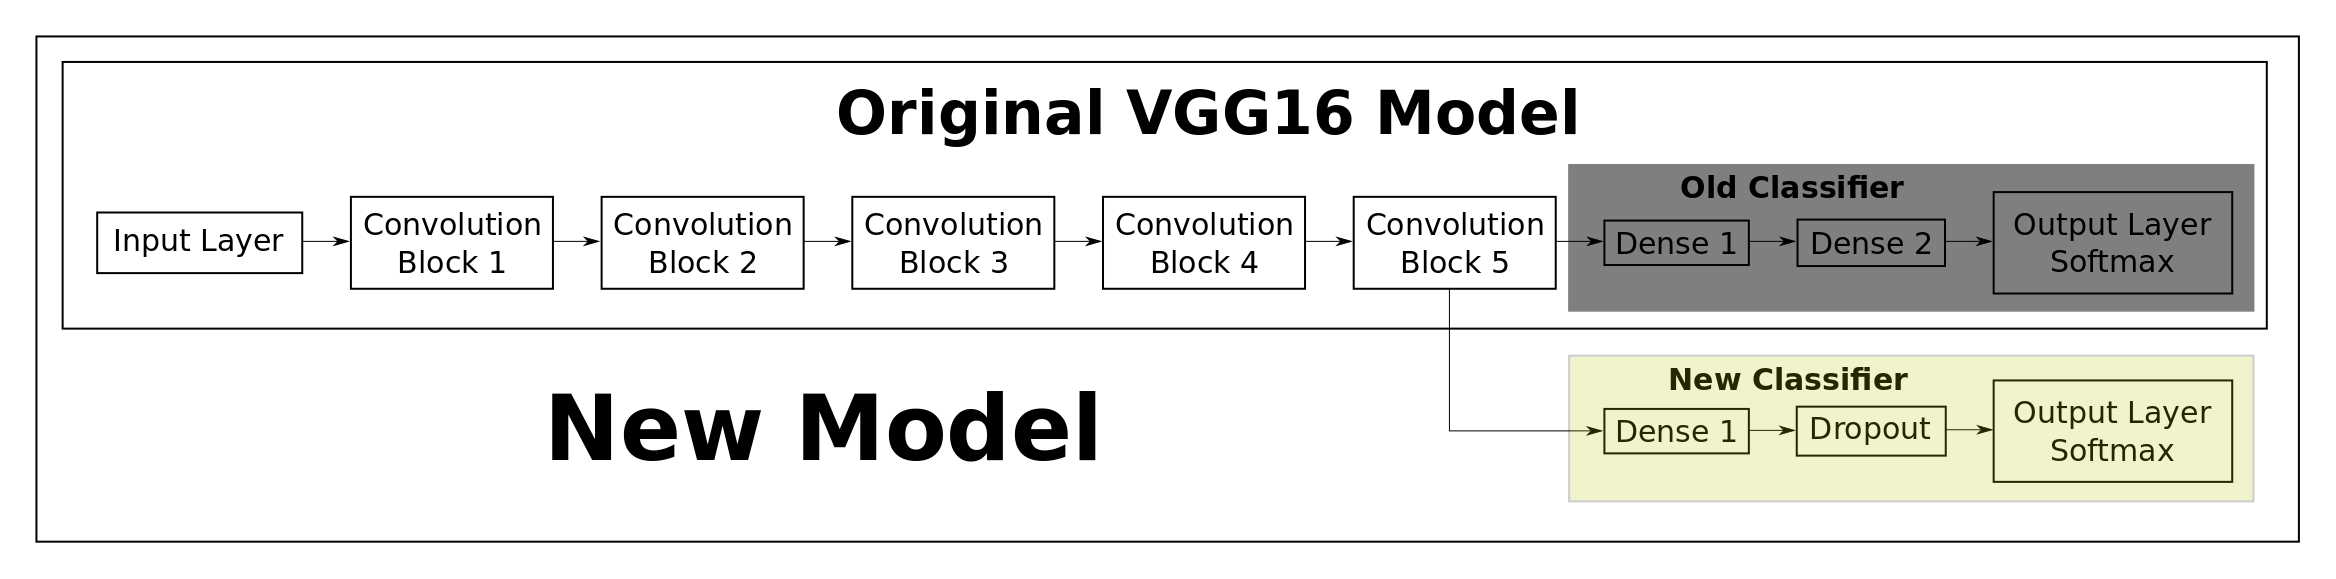

In [1]:
from IPython.display import Image, display
Image('D:\jupyter\\tensorflow_tutorial\images\\10_transfer_learning_flowchart.png')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

c:\deeplearning\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

In [4]:
#Helper-functions

In [5]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [6]:
#Helper-function for plotting images

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    
    assert len(images) == len(cls_true)
    
    #Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)
    
    #Adjust verticak spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    #Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'
        
    for i, ax in enumerate(axes.flat):
        #There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            #plot images.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
#Helper-function for printing confusion matrix.

In [9]:
#Import a function from sklearn to calculate the confusion-matrix.
from  sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [10]:
def plot_example_rights(cls_pred):
    correct = (cls_pred == cls_test)
    image_paths = np.array(image_paths_test)[correct]
    images = load_images(image_paths=image_paths[0:9])
    cls_pred = cls_pred[correct]
    cls_true = cls_test[correct]
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    

In [11]:
def example_rights():
    generator_test.reset()
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    cls_pred = np.argmax(y_pred,axis=1)
    plot_example_rights(cls_pred)

In [12]:
#Helper-function for plotting example errors
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [13]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [14]:
#Helper-function for loading images.
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [15]:
#Helper-function for plotting training history
def plot_training_history(history):
    
    #Get the classification accuracy and loss-value for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['val_loss']
    
    #Plot the accuracy and loss-values for the training-set.
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']
    
    #Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    #Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')
    
    #Plot title and legend.
    plt.title('Training  and Test Accuracy')
    plt.legend()
    
    #Ensure the plot shows correctly.
    plt.show()

In [16]:
#Dataset:Knifey-Spoony

In [17]:
import knifey

In [18]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [19]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


In [20]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

In [21]:
#Pre-Trained Model:VGG 16

In [22]:
model = VGG16(include_top=True, weights='imagenet')

In [23]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [24]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [25]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [26]:
batch_size = 20

In [27]:
if True:
    save_to_dir = None
else:
    save_to_dir = 'augmented_images/'

In [28]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                   target_size=input_shape,
                                                   batch_size=batch_size,
                                                   shuffle=False)

Found 4170 images belonging to 3 classes.


In [29]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

Found 530 images belonging to 3 classes.


In [30]:
steps_test = generator_test.n / batch_size
steps_test

26.5

In [31]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [32]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [33]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

In [34]:
num_classes = generator_train.num_classes
num_classes

3

In [35]:
#Plot a few images to see if data is correct

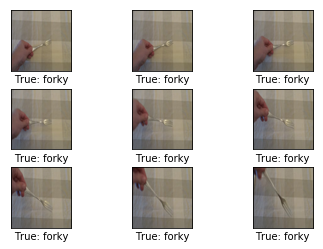

In [36]:
#Load the first images from the train-set
images = load_images(image_paths=image_paths_train[0:9])

#Get the true classes for those images.
cls_true = cls_train[0:9]

#Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [37]:
#Classes weights

In [38]:
from sklearn.utils.class_weight import compute_class_weight

In [39]:
class_weight = compute_class_weight(class_weight='balanced',
                                   classes=np.unique(cls_train),
                                   y=cls_train)

In [40]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [41]:
class_names

['forky', 'knifey', 'spoony']

In [42]:
#Example Predict
def predict(image_path):
    #Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
    
    #Plot the image.
    plt.imshow(img_resized)
    plt.show()
    
    #Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)
    
    #Use the VGG16 model to make a prediction.
    #This outputs an array with 1000 numbers corresponding to
    #the class of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    #Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]
    
    #Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} :{1}".format(score, name))

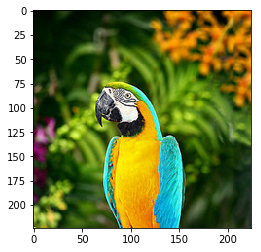

79.02% :macaw
 6.61% :bubble
 3.64% :vine_snake
 1.90% :pinwheel
 1.22% :knot


In [43]:
predict(image_path = 'D:\jupyter\\tensorflow_tutorial\images\parrot_cropped1.jpg')

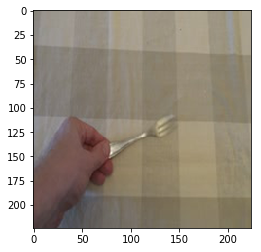

50.31% :shower_curtain
17.08% :handkerchief
12.75% :mosquito_net
 2.87% :window_shade
 1.32% :toilet_tissue


In [44]:
predict(image_path = image_paths_train[0])

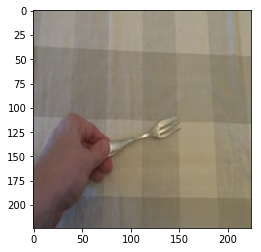

45.08% :shower_curtain
21.84% :mosquito_net
11.55% :handkerchief
 2.02% :window_shade
 0.91% :Windsor_tie


In [45]:
predict(image_path=image_paths_train[1])

In [46]:
#Transfer Learning

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [48]:
transfer_layer = model.get_layer('block5_pool')

In [49]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [50]:
conv_model = Model(inputs=model.input,
                  outputs=transfer_layer.output)

In [51]:
#Use Keras to bulid a new model on top of this.
new_model = Sequential()

#Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

#Flatten the output of the VGG16 model because it is from a 
#convolutional layer.
new_model.add(Flatten())

#Add a dense (aka.fully-connected) layer.
#This is for combining features that the VGG16 model has 
#recongnized in the image.
new_model.add(Dense(1024, activation='relu'))

#Add a dropout-layer which may prevent overfiting and 
#improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

#Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [52]:
optimizer = Adam(lr=1e-5)

In [53]:
loss = 'categorical_crossentropy'

In [54]:
metrics = ['categorical_accuracy']

In [55]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [56]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [57]:
conv_model.trainable = False

In [58]:
for layer in conv_model.layers:
    layer.trainable = False

In [59]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [60]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [61]:
epochs = 20
steps_per_epoch = 100

In [62]:
history = new_model.fit_generator(generator=generator_train,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 class_weight=class_weight,
                                 validation_data=generator_test,
                                 validation_steps=steps_test)

Epoch 1/20
100/100 [==============================]100/100 [==============================] - 61s 611ms/step - loss: 1.3467 - categorical_accuracy: 0.4270 - val_loss: 0.9931 - val_categorical_accuracy: 0.4943

Epoch 2/20
100/100 [==============================]100/100 [==============================] - 58s 577ms/step - loss: 1.2327 - categorical_accuracy: 0.3965 - val_loss: 0.8612 - val_categorical_accuracy: 0.6321

Epoch 3/20
100/100 [==============================]100/100 [==============================] - 58s 576ms/step - loss: 0.9763 - categorical_accuracy: 0.5615 - val_loss: 0.9274 - val_categorical_accuracy: 0.4566

Epoch 4/20
100/100 [==============================]100/100 [==============================] - 57s 573ms/step - loss: 1.0406 - categorical_accuracy: 0.4905 - val_loss: 0.9731 - val_categorical_accuracy: 0.4245

Epoch 5/20
100/100 [==============================]100/100 [==============================] - 57s 574ms/step - loss: 0.9897 - categorical_accuracy: 0.5115 - val

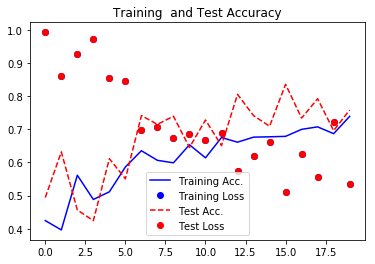

In [63]:
plot_training_history(history)

In [64]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [65]:
print("Test-set classification accuracy:{0:.2%}".format(result[1]))

Test-set classification accuracy:75.85%


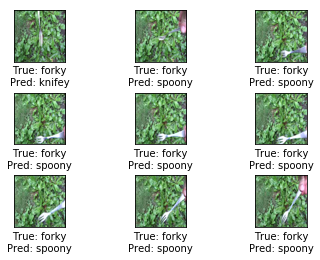

Confusion matrix:
[[ 64  38  49]
 [ 10 111  16]
 [  6   9 227]]
(0) forky
(1) knifey
(2) spoony


In [66]:
example_errors()

In [67]:
#Fine-Tuning

In [68]:
conv_model.trainable = True

In [69]:
for layer in conv_model.layers:
    #Boolean whether this layer is trainable.
    trainable = ('block5' in  layer.name or 'block4' in layer.name)
    
    #Set the layer's bool.
    layer.trainable = trainable

In [70]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [71]:
optimizer_fine = Adam(lr=1e-7)

In [72]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [73]:
history = new_model.fit_generator(generator=generator_train,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 class_weight=class_weight,
                                 validation_data=generator_test,
                                 validation_steps=steps_test)

Epoch 1/20
100/100 [==============================]100/100 [==============================] - 92s 917ms/step - loss: 0.5950 - categorical_accuracy: 0.7485 - val_loss: 0.5286 - val_categorical_accuracy: 0.7755

Epoch 2/20
100/100 [==============================]100/100 [==============================] - 90s 901ms/step - loss: 0.5818 - categorical_accuracy: 0.7510 - val_loss: 0.5212 - val_categorical_accuracy: 0.7906

Epoch 3/20
100/100 [==============================]100/100 [==============================] - 108s 1s/step - loss: 0.6310 - categorical_accuracy: 0.7155 - val_loss: 0.5148 - val_categorical_accuracy: 0.7981

Epoch 4/20
100/100 [==============================]100/100 [==============================] - 90s 902ms/step - loss: 0.5133 - categorical_accuracy: 0.8095 - val_loss: 0.5180 - val_categorical_accuracy: 0.7962

Epoch 5/20
100/100 [==============================]100/100 [==============================] - 90s 898ms/step - loss: 0.6063 - categorical_accuracy: 0.7400 - val_l

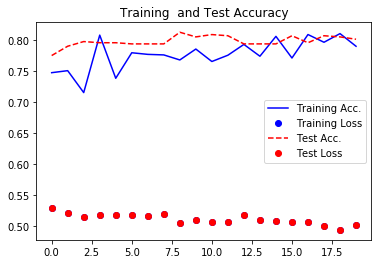

In [74]:
plot_training_history(history)

In [75]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [76]:
print("Test-set classification accuracy:{0:.2%}".format(result[1]))

Test-set classification accuracy:80.19%


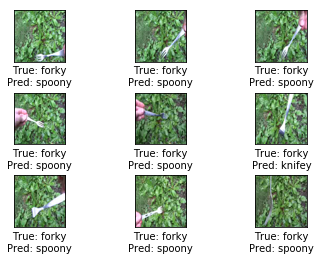

Confusion matrix:
[[136   3  12]
 [ 58  71   8]
 [ 22   2 218]]
(0) forky
(1) knifey
(2) spoony


In [79]:
example_errors()

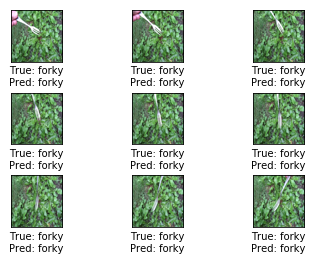

In [80]:
example_rights()